# Example of DOV search methods for observations (observaties)

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/DOV-Vlaanderen/pydov/master?filepath=docs%2Fnotebooks%2Fsearch_observaties.ipynb)

## Use cases explained below
* Get observations in a bounding box
* Get observations with specific properties
* Get observations in a bounding box based on specific properties
* Select observations in a municipality and return depth
* Get observations based on fields not available in the standard output dataframee

In [1]:
%matplotlib inline
import inspect, sys
import warnings; warnings.simplefilter('ignore')

In [2]:
# check pydov path
import pydov

## Get information about the datatype 'Observatie'

In [3]:
from pydov.search.observatie import ObservatieSearch
observatie = ObservatieSearch()

A description is provided for the 'Observatie' datatype:

In [4]:
observatie.get_description()

'DIT IS EEN TEST'

The different fields that are available for objects of the 'Observatie' datatype can be requested with the get_fields() method:

In [5]:
fields = observatie.get_fields()

# print available fields
for f in fields.values():
    print(f['name'])

id
pkey_observatie
pkey_parent
parameter
parametergroep
observatietype
detectieconditie
resultaat
eenheid
fenomeentijd
resultaattijd
methode
uitvoerder
diepte_van_m
diepte_tot_m
herkomst
opmerking
opdracht
geom


You can get more information of a field by requesting it from the fields dictionary:
* *name*: name of the field
* *definition*: definition of this field
* *cost*: currently this is either 1 or 10, depending on the datasource of the field. It is an indication of the expected time it will take to retrieve this field in the output dataframe.
* *notnull*: whether the field is mandatory or not
* *type*: datatype of the values of this field

In [6]:
fields['diepte_van_m']

{'name': 'diepte_van_m',
 'definition': None,
 'type': 'float',
 'list': False,
 'notnull': False,
 'query': True,
 'cost': 1}

## Example use cases

### Get observations in a bounding box

Get data for all the observations that are geographically located within the bounds of the specified box.

The coordinates are in the Belgian Lambert72 (EPSG:31370) coordinate system and are given in the order of lower left x, lower left y, upper right x, upper right y.

In [7]:
from pydov.util.location import Within, Box

df = observatie.search(location=Within(Box(114000, 172310, 114005, 172315)), max_features = 10)
df.head()

[000/001] .


,pkey_observatie,pkey_parent,fenomeentijd,diepte_van_m,diepte_tot_m,parametergroep,parameter,detectieconditie,resultaat,eenheid,methode,uitvoerder,herkomst
0,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/2...,2018-01-09,4.50,4.75,Onderkenning-grondsoort,"Grondsoort volgens ASTM, de beschrijving (ASTM...",NaN,Silt with sand,NaN,Onbekend,VO - Afdeling Geotechniek,LABO
1,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/2...,2018-01-09,NaN,NaN,Volumemassa-watergehalte,Korrelvolumemassa (korrelvolumemassa),NaN,2.65000000,ng/l,Aangenomen,VO - Afdeling Geotechniek,LABO
2,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/2...,2018-01-09,4.75,5.00,Onderkenning-grondsoort,Grondsoort volgens GEO-BGGG (Grondsoort BGGG),NaN,kalkh. zandh. leem,NaN,Classificatie volgens de norm,VO - Afdeling Geotechniek,LABO
3,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/2...,2018-01-09,NaN,NaN,Volumemassa-watergehalte,Watergehalte (watergehalte),NaN,51.70000000,%,Gewichtsverlies na drogen in droogstoof,VO - Afdeling Geotechniek,LABO
4,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/2...,2018-01-09,7.50,8.00,Onderkenning - proeven,Gehalte Kalkachtige stoffen (Gehalte Kalkachti...,NaN,19.10000000,%,Chemische reactie met waterstofchloride,VO - Afdeling Geotechniek,LABO


The dataframe contains several observations made at the same location

Using the *pkey_observatie* field one can request the details of these obsevrations in a webbrowser:

In [8]:
for pkey_observatie in set(df.pkey_observatie):
    print(pkey_observatie)

https://oefen.dov.vlaanderen.be/data/observatie/2022-3489734
https://oefen.dov.vlaanderen.be/data/observatie/2022-1667272
https://oefen.dov.vlaanderen.be/data/observatie/2022-1712990
https://oefen.dov.vlaanderen.be/data/observatie/2022-6766131
https://oefen.dov.vlaanderen.be/data/observatie/2022-2761923
https://oefen.dov.vlaanderen.be/data/observatie/2022-2032153
https://oefen.dov.vlaanderen.be/data/observatie/2022-3535597
https://oefen.dov.vlaanderen.be/data/observatie/2022-4262285
https://oefen.dov.vlaanderen.be/data/observatie/2022-2761922
https://oefen.dov.vlaanderen.be/data/observatie/2022-2807310


### Get observations with specific properties

Next to querying observations based on their geographic location within a bounding box, we can also search for observations matching a specific set of properties. For this we can build a query using a combination of the 'Observatie' fields and operators provided by the WFS protocol.

A list of possible operators can be found below:

In [9]:
[i for i,j in inspect.getmembers(sys.modules['owslib.fes2'], inspect.isclass) if 'Property' in i]

['PropertyIsBetween',
 'PropertyIsEqualTo',
 'PropertyIsGreaterThan',
 'PropertyIsGreaterThanOrEqualTo',
 'PropertyIsLessThan',
 'PropertyIsLessThanOrEqualTo',
 'PropertyIsLike',
 'PropertyIsNotEqualTo',
 'PropertyIsNull',
 'SortProperty']

In this example we build a query using the *PropertyIsEqualTo* operator to find all observations concerning the parameter "Watergehalte (watergehalte)":

In [10]:
from owslib.fes2 import PropertyIsEqualTo

query = PropertyIsEqualTo(propertyname='parameter',
                          literal='Watergehalte (watergehalte)')
df = observatie.search(query=query, max_features = 10)

df.head()

[000/001] .


,pkey_observatie,pkey_parent,fenomeentijd,diepte_van_m,diepte_tot_m,parametergroep,parameter,detectieconditie,resultaat,eenheid,methode,uitvoerder,herkomst
0,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/2...,2006-10-27,NaN,NaN,Volumemassa-watergehalte,Watergehalte (watergehalte),NaN,20.60000000,NaN,Gewichtsverlies na drogen in droogstoof,VO - Afdeling Geotechniek,LABO
1,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/2...,2005-03-22,NaN,NaN,Volumemassa-watergehalte,Watergehalte (watergehalte),NaN,37.00000000,NaN,Gewichtsverlies na drogen in droogstoof,MVG - Afdeling Geotechniek,LABO
2,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/2...,2008-06-27,NaN,NaN,Volumemassa-watergehalte,Watergehalte (watergehalte),NaN,40.00000000,NaN,Gewichtsverlies na drogen in droogstoof,VO - Afdeling Geotechniek,LABO
3,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/2...,2009-08-07,NaN,NaN,Volumemassa-watergehalte,Watergehalte (watergehalte),NaN,35.30000000,NaN,Gewichtsverlies na drogen in droogstoof,VO - Afdeling Geotechniek,LABO
4,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/2...,2009-09-28,NaN,NaN,Volumemassa-watergehalte,Watergehalte (watergehalte),NaN,23.30000000,NaN,Gewichtsverlies na drogen in droogstoof,VO - Afdeling Geotechniek,LABO


Once again we can use the *pkey_observatie* as a permanent link to the information of these observations:

In [11]:
for pkey_observatie in set(df.pkey_observatie):
    print(pkey_observatie)

https://oefen.dov.vlaanderen.be/data/observatie/2022-1301147
https://oefen.dov.vlaanderen.be/data/observatie/2022-1301055
https://oefen.dov.vlaanderen.be/data/observatie/2022-1301125
https://oefen.dov.vlaanderen.be/data/observatie/2022-1301180
https://oefen.dov.vlaanderen.be/data/observatie/2022-1301111
https://oefen.dov.vlaanderen.be/data/observatie/2022-1301000
https://oefen.dov.vlaanderen.be/data/observatie/2022-1301094
https://oefen.dov.vlaanderen.be/data/observatie/2022-1301217
https://oefen.dov.vlaanderen.be/data/observatie/2022-1300859
https://oefen.dov.vlaanderen.be/data/observatie/2022-1301177


### Get observations in a bounding box based on specific properties

We can combine a query on attributes with a query on geographic location to get the observations within a bounding box that have specific properties.

The following example requests the observations where the parameter 'Watergehalte (watergehalte)' is greater than 30 and within the given bounding box.

(Note that the datatype of the *literal* parameter should be a string, regardless of the datatype of this field in the output dataframe.)

In [12]:
from owslib.fes2 import PropertyIsGreaterThanOrEqualTo, And

query = And([PropertyIsGreaterThanOrEqualTo(propertyname='resultaat',literal='30'),
            PropertyIsEqualTo(propertyname='parameter', literal='Watergehalte (watergehalte)')])

df = observatie.search(
    location=Within(Box(114000, 172310, 114005, 172315)),
    query=query,
    max_features = 10
    )

df.head()

[000/001] .


,pkey_observatie,pkey_parent,fenomeentijd,diepte_van_m,diepte_tot_m,parametergroep,parameter,detectieconditie,resultaat,eenheid,methode,uitvoerder,herkomst
0,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/2...,2018-01-09,NaN,NaN,Volumemassa-watergehalte,Watergehalte (watergehalte),NaN,51.70000000,%,Gewichtsverlies na drogen in droogstoof,VO - Afdeling Geotechniek,LABO
1,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/2...,2018-01-09,NaN,NaN,Volumemassa-watergehalte,Watergehalte (watergehalte),NaN,36.30000000,%,Gewichtsverlies na drogen in droogstoof,VO - Afdeling Geotechniek,LABO


We can look at one of theobservations in a webbrowser using its *pkey_observatie*:

In [13]:
for pkey_observatie in set(df.pkey_observatie):
    print(pkey_observatie)

https://oefen.dov.vlaanderen.be/data/observatie/2022-2761922
https://oefen.dov.vlaanderen.be/data/observatie/2022-2533717


### Select observations with extra details

We can ask extra info from an observation from the XML. In this example we want the details of an observation

In [ ]:
from pydov.search.observatie import ObservatieSearch
from pydov.types.observatie import Observatie, ObservatieDetails

observatie = ObservatieSearch(objecttype=Observatie.with_extra_fields(ObservatieDetails)
   )

df = observatie.search(max_features=10)
df.head()

[000/001] .
[000/010] cccccccccc


,pkey_observatie,pkey_parent,fenomeentijd,diepte_van_m,diepte_tot_m,parametergroep,parameter,detectieconditie,resultaat,eenheid,methode,uitvoerder,herkomst,betrouwbaarheid,geobserveerd_object_type,geobserveerd_object_naam,geobserveerd_object_permkey
0,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/bodemsite...,2024-01-03,NaN,NaN,Bodem_terrein,Vegetatie (vegetatie),NaN,Grassen,-,Visuele waarneming (Cmon staalnameprotocol),NaN,VELD,NaN,NaN,NaN,NaN
1,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/bodemsite...,2024-01-03,NaN,NaN,Bodem_terrein,Ah of Ap horizont - dikte (horizont_Ah_Ap_dikte),NaN,2,cm,Cmon staalnameprotocol,NaN,VELD,NaN,NaN,NaN,NaN
2,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/bodemsite...,2024-01-03,NaN,NaN,Bodem_terrein,Landgebruik EUNIS (landgebruik_eunis),NaN,R2 (Mesic grasslands),NaN,Visuele waarneming (Cmon staalnameprotocol),NaN,VELD,NaN,NaN,NaN,NaN
3,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/bodemsite...,2024-01-03,NaN,NaN,Bodem_terrein,Reliëf - positie op de helling (relief_helling...,NaN,Midden,NaN,Visuele waarneming (Cmon staalnameprotocol),NaN,VELD,NaN,NaN,NaN,NaN
4,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/bodemsite...,2024-01-03,NaN,NaN,Bodem_terrein,Reliëf - aanwezigheid helling (relief_helling_...,NaN,Ja,NaN,Visuele waarneming (Cmon staalnameprotocol),NaN,VELD,NaN,NaN,NaN,NaN


### Select observations with specific conditions and return the results

We can limit the columns in the output dataframe by specifying the *return_fields* parameter in our search.

In this example we query all the observations that have a value (resultaat) greater than 10 for parameter 'Watergehalte (watergehalte)' and	return its value (resultaat):

In [14]:
query = And([PropertyIsGreaterThanOrEqualTo(propertyname='resultaat',literal='10'),
            PropertyIsEqualTo(propertyname='parameter', literal='Watergehalte (watergehalte)')])
df = observatie.search(query=query,
                   return_fields=('resultaat',),
                      max_features=10)
df.head()

[000/001] .


,resultaat
0,20.60000000
1,37.00000000
2,40.00000000
3,35.30000000
4,23.30000000


In [15]:
df.describe()

,resultaat
count,10
unique,10
top,20.60000000
freq,1


By discarding the observations with a resultaat less than 50, we get a different result:

In [16]:
df[df.resultaat.astype(float) < 50.0].describe()

,resultaat
count,9
unique,9
top,20.60000000
freq,1


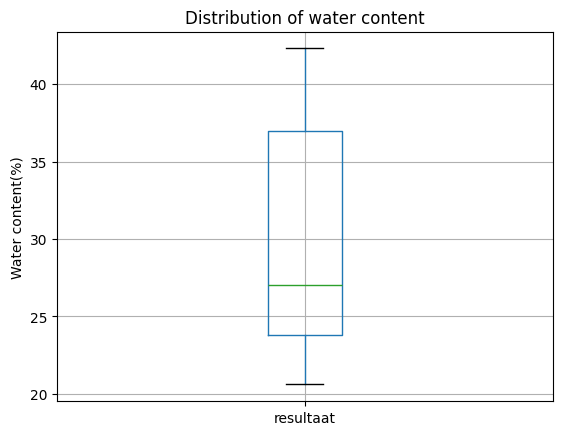

In [17]:
ax = df[df.resultaat.astype(float) < 50.0].astype(float).boxplot()
ax.set_ylabel("Water content(%)");
ax.set_title("Distribution of water content");

### Get observations based on fields not available in the standard output dataframe

To keep the output dataframe size acceptable, not all available WFS fields are included in the standard output. However, one can use this information to select observations as illustrated below.

For example, make a selection of the observations that have an 'opdracht':

In [18]:
from owslib.fes2 import Not
from owslib.fes2 import PropertyIsNull

query = Not([PropertyIsNull(propertyname='opdracht')])

df = observatie.search(query=query, max_features = 10,
                   return_fields=('pkey_observatie', 'opdracht'))
df.head()

[000/001] .


,pkey_observatie,opdracht
0,https://oefen.dov.vlaanderen.be/data/observati...,|Curieuzeneuzen in de tuin 2021|Curieuzeneuzen...
1,https://oefen.dov.vlaanderen.be/data/observati...,|Curieuzeneuzen in de tuin 2021|Curieuzeneuzen...
2,https://oefen.dov.vlaanderen.be/data/observati...,|Curieuzeneuzen in de tuin|Curieuzeneuzen in d...
3,https://oefen.dov.vlaanderen.be/data/observati...,|Curieuzeneuzen in de tuin|Curieuzeneuzen in d...
4,https://oefen.dov.vlaanderen.be/data/observati...,|Curieuzeneuzen in de tuin|Curieuzeneuzen in d...


## Visualize results

Using Geopandas GeoDataFrame, we can easily display the results of our search on a map.

In [19]:
import geopandas as gpd

query = And([PropertyIsGreaterThanOrEqualTo(propertyname='resultaat',literal='10'),
            PropertyIsEqualTo(propertyname='parameter', literal='Watergehalte (watergehalte)')])
df = observatie.search(query=query,
                   return_fields=('pkey_observatie','resultaat','geom'), max_features = 100)

[000/001] .


In [20]:
gdf = gpd.GeoDataFrame(df, geometry='geom', crs='EPSG:31370')
gdf.explore()